In [ ]:
import yfinance as yf

# Fetch Real-Life Data
def fetch_data():
    # Portfolio: SPY (S&P 500 ETF)
    portfolio_data = yf.download("SPY", start="2020-01-01", end="2022-12-31")
    # Market: S&P 500 Index
    market_data = yf.download("^GSPC", start="2020-01-01", end="2022-12-31")
    # Risk-Free Rate: 10-Year Treasury Yield (^IRX)
    treasury_yield_data = yf.download("^IRX", start="2020-01-01", end="2022-12-31")

    # Use 'Adj Close' or fallback to 'Close'
    portfolio_prices = portfolio_data['Adj Close'] if 'Adj Close' in portfolio_data.columns else portfolio_data['Close']
    market_prices = market_data['Adj Close'] if 'Adj Close' in market_data.columns else market_data['Close']
    risk_free_rate = treasury_yield_data['Adj Close'] if 'Adj Close' in treasury_yield_data.columns else treasury_yield_data['Close']

    return portfolio_prices, market_prices, risk_free_rate

# Fetch the data
portfolio_prices, market_prices, risk_free_rate = fetch_data()

# Risk-Free Rate: Convert to daily return
risk_free_rate = (risk_free_rate / 100) / 252  # Annualized rate to daily


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Calculate daily returns
portfolio_returns = portfolio_prices.pct_change().dropna()
market_returns = market_prices.pct_change().dropna()

# Combine data into a single DataFrame
import pandas as pd
data = pd.concat([portfolio_returns, market_returns, risk_free_rate], axis=1)
data.columns = ['Portfolio', 'Market', 'Risk-Free']
data = data.dropna()


In [ ]:
from sklearn.linear_model import LinearRegression

# Reshape data for regression
X = data['Market'].values.reshape(-1, 1)
y = data['Portfolio'].values.reshape(-1, 1)

# Perform linear regression to calculate beta
reg = LinearRegression().fit(X, y)
beta = reg.coef_[0][0]  # Beta is the slope of the regression line
print(f"Portfolio Beta: {beta:.4f}")


Portfolio Beta: 0.9808


In [ ]:
# Calculate market excess return
data['Market_Excess'] = data['Market'] - data['Risk-Free']

# Calculate expected return using CAPM
data['Expected_Return'] = data['Risk-Free'] + beta * data['Market_Excess']


In [ ]:
# Calculate Jensen's Alpha
data['Alpha'] = data['Portfolio'] - data['Expected_Return']

# Annualized Jensen’s Alpha
annualized_alpha = data['Alpha'].mean() * 252
print(f"Annualized Jensen's Alpha: {annualized_alpha:.4f}")


Annualized Jensen's Alpha: 0.0159


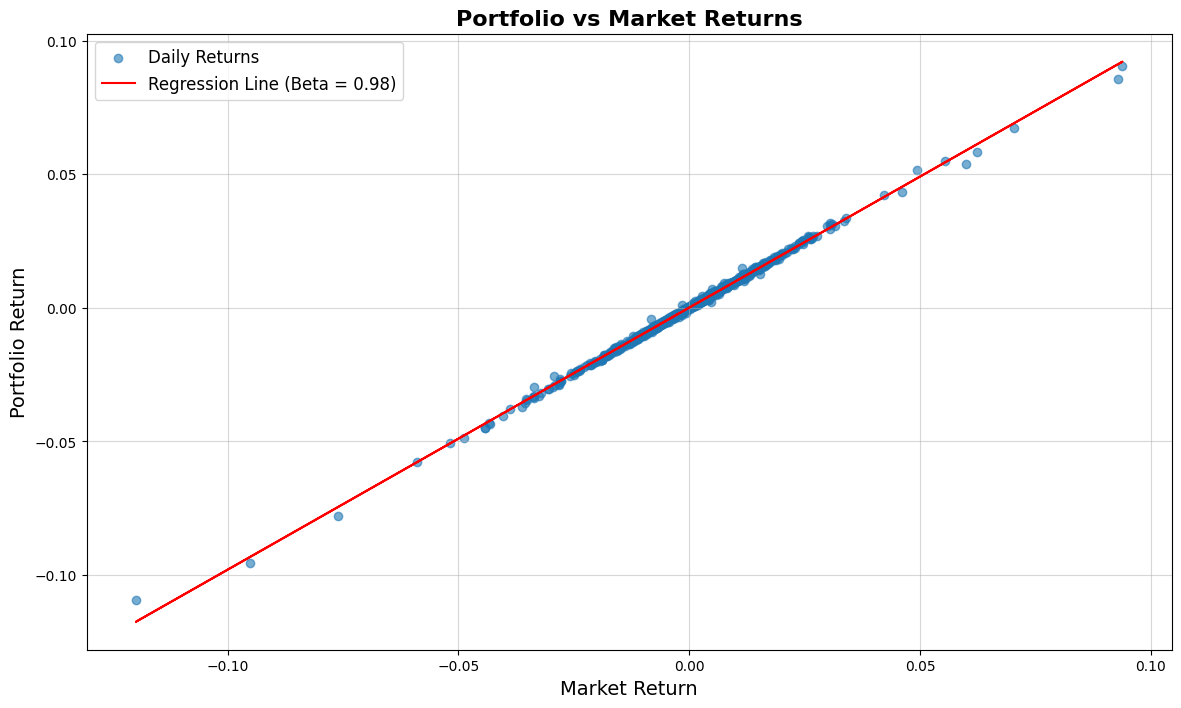

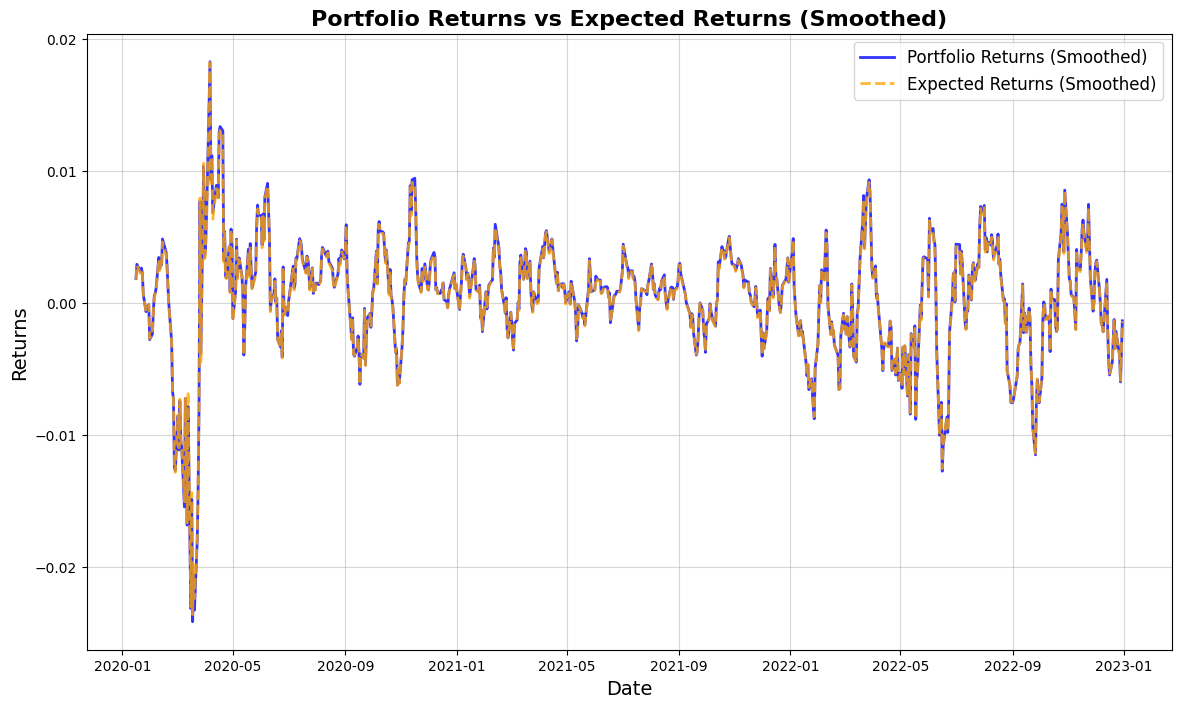

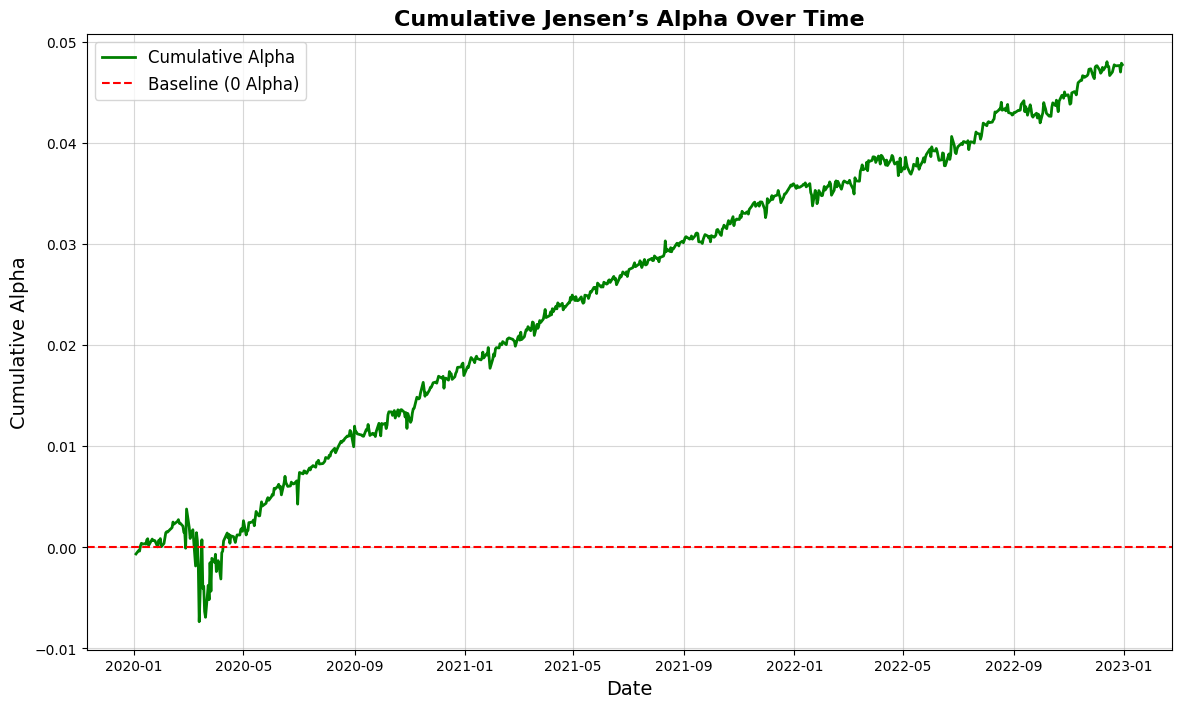

In [ ]:
import matplotlib.pyplot as plt

# Plot 1: Portfolio vs Market Returns with Regression Line
plt.figure(figsize=(14, 8))
plt.scatter(data['Market'], data['Portfolio'], alpha=0.6, label="Daily Returns", color="#1f77b4")
plt.plot(data['Market'], reg.predict(X), color='red', label=f"Regression Line (Beta = {beta:.2f})")
plt.title("Portfolio vs Market Returns", fontsize=16, fontweight='bold')
plt.xlabel("Market Return", fontsize=14)
plt.ylabel("Portfolio Return", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot 2: Portfolio Returns vs Expected Returns
data['Portfolio_Smoothed'] = data['Portfolio'].rolling(window=10).mean()
data['Expected_Smoothed'] = data['Expected_Return'].rolling(window=10).mean()

plt.figure(figsize=(14, 8))
plt.plot(data['Portfolio_Smoothed'], label='Portfolio Returns (Smoothed)', alpha=0.8, color='blue', linewidth=2)
plt.plot(data['Expected_Smoothed'], label='Expected Returns (Smoothed)', linestyle='--', alpha=0.8, color='orange', linewidth=2)
plt.title("Portfolio Returns vs Expected Returns (Smoothed)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Returns", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot 3: Cumulative Jensen’s Alpha Over Time
data['Cumulative_Alpha'] = data['Alpha'].cumsum()
plt.figure(figsize=(14, 8))
plt.plot(data['Cumulative_Alpha'], label="Cumulative Alpha", color="green", linewidth=2)
plt.axhline(0, color="red", linestyle="--", label="Baseline (0 Alpha)")
plt.title("Cumulative Jensen’s Alpha Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Alpha", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


[*********************100%***********************]  2 of 2 completed


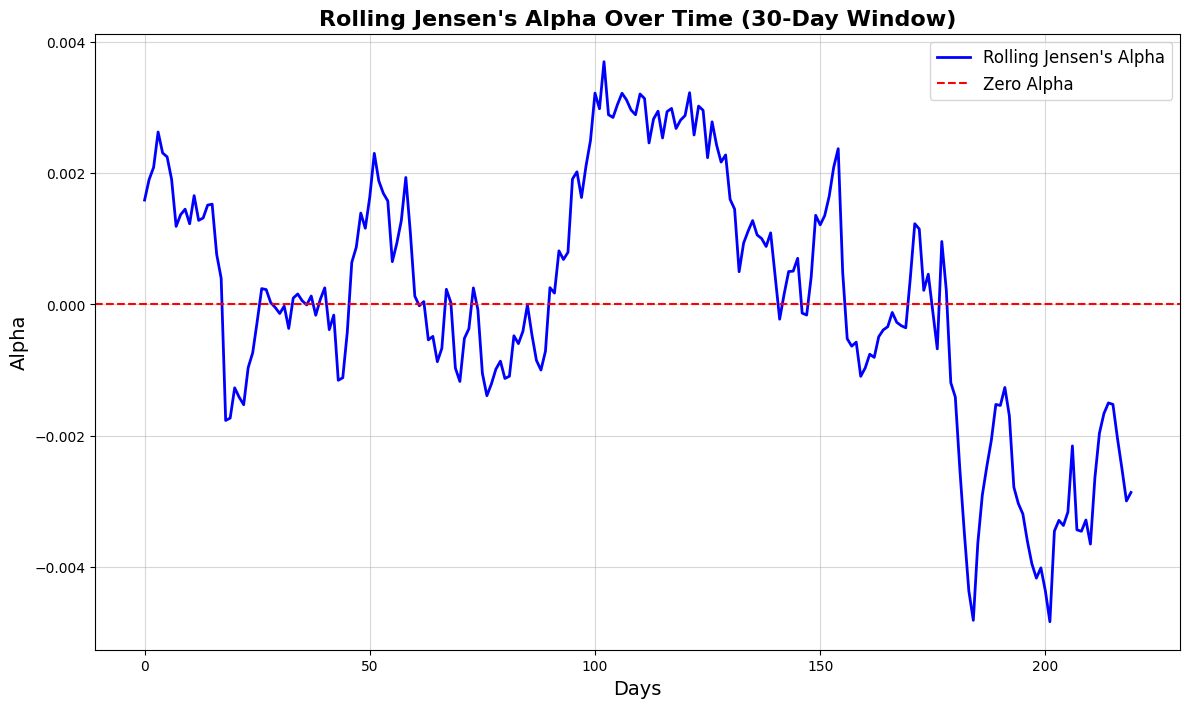

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers
portfolio_ticker = "AAPL"  # Portfolio (Apple)
market_ticker = "^GSPC"    # Market benchmark (S&P 500)

# Download data
data = yf.download([portfolio_ticker, market_ticker], start="2022-01-01", end="2023-01-01")['Close']

# Calculate daily returns
returns = data.pct_change().dropna()
portfolio_returns = returns[portfolio_ticker]
market_returns = returns[market_ticker]

# Risk-free rate (annualized, e.g., 2%)
risk_free_rate = 0.02 / 252

# Rolling window (30 days)
rolling_window = 30
rolling_alpha = []

for i in range(len(portfolio_returns) - rolling_window):
    # Extract rolling window
    window_portfolio = portfolio_returns[i:i + rolling_window]
    window_market = market_returns[i:i + rolling_window]

    # Calculate beta (Covariance of portfolio & market / Variance of market)
    beta = np.cov(window_portfolio, window_market)[0][1] / np.var(window_market)

    # Calculate expected return using CAPM
    expected_return = risk_free_rate + beta * (np.mean(window_market) - risk_free_rate)

    # Calculate alpha (Actual Return - Expected Return)
    actual_return = np.mean(window_portfolio)
    alpha = actual_return - expected_return
    rolling_alpha.append(alpha)

# Plot Rolling Jensen’s Alpha
plt.figure(figsize=(14, 8))
plt.plot(rolling_alpha, label="Rolling Jensen's Alpha", color='blue', linewidth=2)
plt.axhline(0, color='red', linestyle='--', label="Zero Alpha")
plt.title("Rolling Jensen's Alpha Over Time (30-Day Window)", fontsize=16, fontweight='bold')
plt.xlabel("Days", fontsize=14)
plt.ylabel("Alpha", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


[*********************100%***********************]  4 of 4 completed


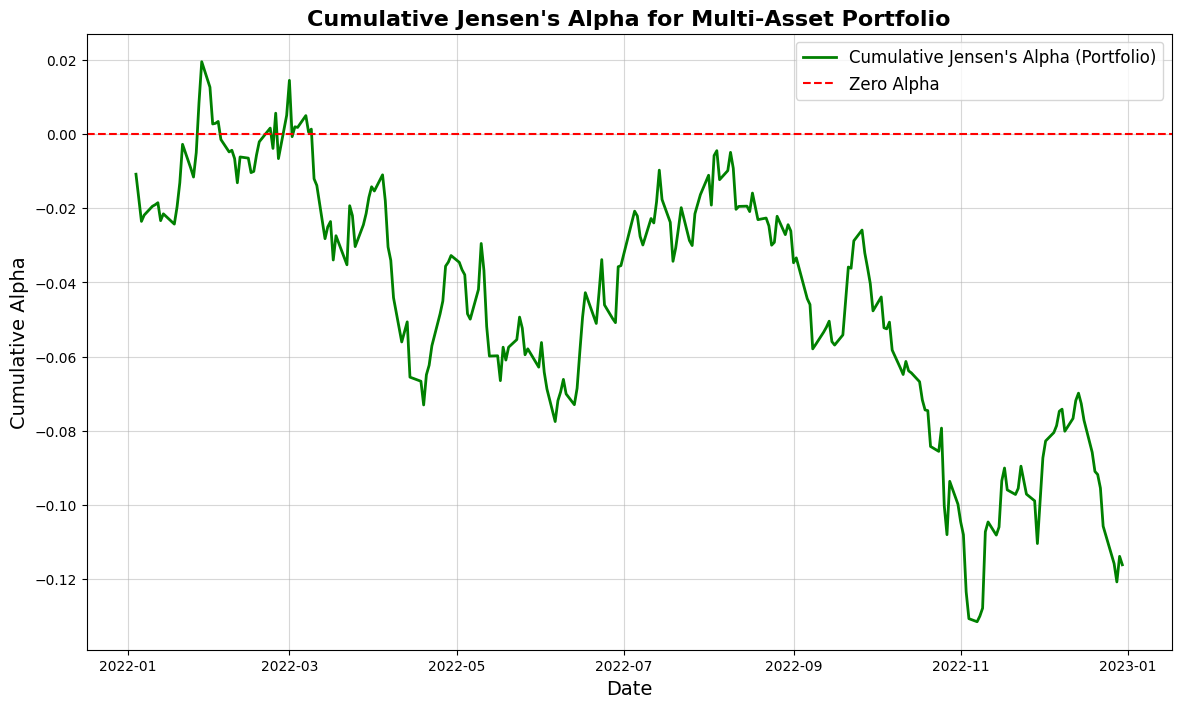

In [ ]:
# Define tickers for multi-asset portfolio
tickers = ["AAPL", "MSFT", "TLT"]  # Apple, Microsoft, Long-term Treasury ETF
market_ticker = "^GSPC"

data = yf.download(tickers + [market_ticker], start="2022-01-01", end="2023-01-01")['Close']

# Calculate daily returns
returns = data.pct_change().dropna()
portfolio_returns = returns[tickers].mean(axis=1)  # Equal-weighted portfolio returns
market_returns = returns[market_ticker]

# Risk-free rate (annualized, e.g., 2%)
risk_free_rate = 0.02 / 252

# Calculate beta for the portfolio
cov_matrix = np.cov(portfolio_returns, market_returns)
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

# Calculate expected return using CAPM
market_excess_return = market_returns - risk_free_rate
expected_return = risk_free_rate + beta * market_excess_return

# Calculate Jensen's Alpha for the multi-asset portfolio
alpha = portfolio_returns - expected_return

# Plot cumulative alpha
cumulative_alpha = alpha.cumsum()
plt.figure(figsize=(14, 8))
plt.plot(cumulative_alpha, label="Cumulative Jensen's Alpha (Portfolio)", color="green", linewidth=2)
plt.axhline(0, color="red", linestyle="--", label="Zero Alpha")
plt.title("Cumulative Jensen's Alpha for Multi-Asset Portfolio", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Alpha", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


In [ ]:
# Define tickers for different sectors
sector_tickers = {
    "Technology": ["AAPL", "MSFT", "NVDA"],
    "Utilities": ["NEE", "DUK", "SO"]
}
market_ticker = "^GSPC"

# Download data
data = {}
for sector, tickers in sector_tickers.items():
    data[sector] = yf.download(tickers + [market_ticker], start="2022-01-01", end="2023-01-01")['Close']

# Calculate Jensen's Alpha for each sector
sector_alpha = {}
for sector, prices in data.items():
    # Calculate returns
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.drop(columns=market_ticker).mean(axis=1)  # Equal-weighted sector portfolio
    market_returns = returns[market_ticker]

    # Risk-free rate
    risk_free_rate = 0.02 / 252

    # Beta
    cov_matrix = np.cov(portfolio_returns, market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]

    # Expected return
    expected_return = risk_free_rate + beta * (market_returns.mean() - risk_free_rate)

    # Alpha
    sector_alpha[sector] = (portfolio_returns.mean() - expected_return)

# Display sector results
for sector, alpha in sector_alpha.items():
    print(f"Jensen's Alpha for {sector}: {alpha:.4f}")


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


Jensen's Alpha for Technology: -0.0001
Jensen's Alpha for Utilities: 0.0006
